In [1]:
import pandas as pd
import numpy as np
import math

from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import IsolationForest # detects outliers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
movies_df = pd.read_csv('movie_metadata.csv')

#creates a profile document which analyses each of the variables in the dataframe 
# movies_profile = ProfileReport(movies, title = "Movie Report", explorative=True)
# movies_profile.to_file("movies.html")

# Information Gained From the Profile

**Numerical**

director_facebook_likes, *duration*,  actor_1_facebook_likes, actor_2_facebook_likes, actor_3_facebook_likes, cast_total_facebook_likes, movie_facebook_likes, 

num_voted_users, num_critic_for_reviews,  num_user_for_reviews   

gross, budget,

*imbd_score*, facenumber_in_poster

*Italitized items have close to a normal distribution. The rest of the values are skewed.*

**Categorical**

*director_name, actor_1_name, actor_2_name, actor_3_name*

language, country, content_rating

*movie_title, movie_imdb_link*,  aspect_ratio, color

*Italitized items have high cardinality.*

**Imbalanced Variables**: color, language, country

**List Variables**: genres, plot keywords

**Large Percentage Missing**: director_facebook_likes, gross, budget, title_year

**Extreme Values** : Most of the numerical values have outliers/extreme values. 

* About half of the varaiables contained information that could be used to plan future productions. 
* The other half of the information was about things that studios would have little or no control over, such as the number of facebook likes or reviewer on imdb.
* Some of the variables, like director and actor, had a lot of different possible values.  This could make it more difficult to use with Machine Learning algorithms.
* The first movie in the database was from 1916.  Movies that are from far in the past might not be as good at helping to predict future movie sales.
* Data was heavily scewed towards color movies, english language and movies made in the US. As most movies are made in color now, this variable could probably be dropped. Language and country data would either need some processing before use or to drop them as well.
* Most of the data did not have missing values. Unfortunately, budget and gross, two of the more important ones for this analysis had a high percentage of missing values.
* Very few of the values had normal distribution.  Some of this was likely due the changes in technology over time and inflation.
* Many of the values had high correlations between them. Some of this was also likely due to changes over time.
* Both budget and gross had an extremely wide spread.  Part of this was probably due to inflation. Adjusting amounts for inflation might help with this to some extent.

In [3]:
# create a new column, transform 'genres' and 'plot_keywords' into lists, 
# store the lists in the new columns
movies_df['genre_list'] = movies_df['genres'].copy()
movies_df['genre_list'] = movies_df['genre_list'].str.split('|')

# movies_df['keyword_list'] = movies_df['plot_keywords'].copy()
# movies_df['keyword_list'] = movies_df['keyword_list'].str.split('|')

# create boolean columns for each genre

genres = set([item for lists in movies_df['genre_list'] for item in lists])

# Below code was taken from: 
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
# Create empty dict
genre_dict = {}

# Loop through all the tags
for i, item in enumerate(genres):
    # Apply boolean mask
    genre_dict[item] = movies_df['genre_list'].apply(lambda x: item in x)

# Return the results as a dataframe, change True and false values to 0 and 1
genre_frame =  pd.DataFrame(genre_dict)
genre_frame = genre_frame.astype(int)


movies_df = pd.merge(movies_df, genre_frame, left_index = True, right_index = True)
movies_df.drop(columns = ['genre_list'], inplace = True)
movies_df.drop_duplicates(inplace = True)


Using an API, new information about budget and gross revenue was obtained from the movie database. This information was saved in a csv. https://github.com/MariannBea/Movie-Studio-Analysis/blob/791fa7539162859b022dd0e35b89297d64639738/Get%20Budget%20Info.ipynb

In [4]:
# #load information from API
# budget_data = pd.read_csv("movie_budget_data.csv")
# budget_data.rename(columns = {'0': 'title', '1':'budget', '2':'gross'}, inplace = True)
# # movies_df['budget'].fillna(0, inplace = True)

# #replace information in database with information from API 
# #SOMETHING IS NOT WORKING HERE _ IT SEEM TO BE ADDING NEW INFORMATION TO THE DATABASE

# for index, title, budget, gross in budget_data.itertuples():
#     strbudget = str(budget)
#     strgross = str(gross)
#     strtitle = title
#     if budget != 0:
#         movies_df.loc[title, 'budget'] = gross
#     if gross != 0:
#         movies_df.loc[title, 'gross'] = gross

Budget and gross movie information needs to be adjusted for inflation over time. 

Inflation information was found at: https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG 

Some countries were not present in the data. The countries on the left were give the values for the country or region on the right as they were closest economic match. 

* Argentina: Latin America & Caribbean 
* Finland: EU Indonesia: East Asia & Pacific (excluding high income) 
* South Korea: East Asia & Pacific 
* Taiwan: China 
* Thailand: East Asia & Pacific (excluding high income) 
* West Germany - Russia Soviet Union - Russia

In [5]:
inflation = pd.read_csv("price_index.csv")

# calculate mean inflation rate for each country.  Use this rate to fill in NaN values    

inflation['mean'] = inflation.mean(axis = 1, numeric_only = True)
inflation = inflation.set_index('country')

# fill missing years with 2005, missing countries with USA (most common)
movies_df['title_year'].fillna(2005, inplace = True)
movies_df['country'].fillna('USA', inplace = True)

#determine inflation rate for each movie, movies before 1960 given mean inflation rate
movies_df['title_year'] = movies_df['title_year'].astype(int)

movies_df[['budget', 'gross']].dropna()

for index, year, country in movies_df[['title_year', 'country']].itertuples():
    stryear = str(year)
    strcountry = str(country)
    if year >= 1960:
        movies_df['rate'] = inflation.loc[[strcountry],[stryear]].iloc[0][0]
    else:
        movies_df['rate'] = inflation.loc[[strcountry],['mean']].iloc[0][0]

# find budget and gross adjusted for inflation
movies_df['budget_infl'] = (movies_df['budget']/movies_df['rate']) * 100
movies_df['gross_infl'] = (movies_df['gross']/movies_df['rate']) * 100

#calculate movie profits
movies_df['profit'] = movies_df['gross_infl'] - movies_df['budget_infl']


There were several very similar content ratings.  These were combined into categories based on their general age appropriateness.  These categories will be used to look for a correlation between the age that content in created for and profits.  It will also be used to investigate if there is some correlation between profitability and particular genres related to specific age groups.

In [6]:
#consolidate ratings into smaller categories
movies_df['content_rating'].replace({'Not Rated': 'Unrated', 'Approved': 'Unrated', 
                                           'TV-G': 'G',  'TV-PG': 'PG', 'TV-MA': 'R',
                                           'TV-Y': 'G', 'TV-14': 'PG-13', 'Passed': 'Not Rated',
                                           'TV-Y7': 'PG', 'M': 'PG', 'GP': 'PG'}, inplace = True)

More recent movies are more likely to have a predictive value for what features in future movies are likely to lead to success.  1999 was chosen as the initial cut off date because it was the low end of the interquartile range from the orignal set of data.  However, both a wider and narrower date range will be explored.

In [7]:
#create a database for movies that are after 1999
recent_movies = movies_df.loc[movies_df['title_year'] >= 1999]
recent_movies = recent_movies.drop(columns = ['color', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews'])

I wanted to see if there was a correlation between the number of movies a director or actor participated in and profits.  My first attempt (3 - 4 cells below this), just counted the number of movies or frequency each person was in.  However, this isn't accurate to reality.  A director who directed 43 movies, didn't direct 43 movies when they were making thier first movie.  So, the code below tries to more accurately reflect the number of movies the person was involved in at the point of time that the movie was made.  First the movies were sorted by year.  Then each time a person was involved in a movie, their count was incremented by one.

In [8]:
recent_movies = recent_movies.sort_values(by = ['title_year']).reset_index(drop = True)

director_count = {}

for index, title, director, year in recent_movies[['movie_title','director_name', 'title_year']].itertuples():
    if director in director_count:
        recent_movies.loc[recent_movies['movie_title'] == title,'director_count'] = (director_count[director] + 1)
        director_count[director] += 1
    else:
        recent_movies.loc[recent_movies['movie_title'] == title,'director_count'] = 1
        director_count[director] = 1

In [9]:
actor_count = {}

for index, title, actor1, actor2, actor3 in recent_movies[['movie_title','actor_1_name', 'actor_2_name', 'actor_3_name']].itertuples():
    if actor1 in actor_count:
        recent_movies.loc[recent_movies['movie_title'] == title,'actor1_count'] = (actor_count[actor1] + 1)
        actor_count[actor1] += 1
    else:
        recent_movies.loc[recent_movies['movie_title'] == title,'actor1_count'] = 1
        actor_count[actor1] = 1
    if actor2 in actor_count:
        recent_movies.loc[recent_movies['movie_title'] == title,'actor2_count'] = (actor_count[actor2] + 1)
        actor_count[actor1] += 1
    else:
        recent_movies.loc[recent_movies['movie_title'] == title,'actor2_count'] = 1
        actor_count[actor2] = 1
    if actor3 in actor_count:
        recent_movies.loc[recent_movies['movie_title'] == title,'actor3_count'] = (actor_count[actor3] + 1)
        actor_count[actor1] += 1
    else:
        recent_movies.loc[recent_movies['movie_title'] == title,'actor3_count'] = 1
        actor_count[actor3] = 1

###### The code below was my first attempt at counting the number of movies that a director or actor was involved in .

To determine if their is a correlation between the number of movies a director or actor was involved in and profits, the number of movies for each director or actor needs to be tallied.  The value for the director was calculated as its relative frequency compared to the other movies.

#add a column showing relative frequency of movies directed by a particular director
num_movies = recent_movies['director_name'].value_counts(normalize = True).reset_index(drop = True)
num_movies.columns = ['director_name', 'director_count']
recent_movies = pd.merge(recent_movies, num_movies, on = 'director_name')

recent_movies = recent_movies.sort_values(by = ['title_year'])
#find frequency of each actor
actor1_num_movies = pd.DataFrame(recent_movies[['actor_1_name']].value_counts()).reset_index()
actor2_num_movies = pd.DataFrame(recent_movies[['actor_2_name']].value_counts()).reset_index()
actor3_num_movies = pd.DataFrame(recent_movies[['actor_3_name']].value_counts()).reset_index()


#create a dictionary with the total count of actors across actor1, actor2 and actor 3
actor_dict = { }

for index1, actor1, count1 in actor1_num_movies.itertuples():
    if actor1 in actor_dict:
        actor_dict[actor1] += count1
    else: 
        actor_dict[actor1] = count1

for index2, actor2, count2 in actor2_num_movies.itertuples():
    if actor2 in actor_dict:
        actor_dict[actor2] += count2
    else: 
        actor_dict[actor2] = count2
        
for index3, actor3, count3 in actor3_num_movies.itertuples():
    if actor3 in actor_dict:
        actor_dict[actor3] += count3
    else: 
        actor_dict[actor3] = count3  

#add actor count column to data frame
recent_movies['actor1_count'] = recent_movies['actor_1_name'].apply(lambda x: actor_dict.get(x))
recent_movies['actor2_count'] = recent_movies['actor_2_name'].apply(lambda x: actor_dict.get(x))
recent_movies['actor3_count'] = recent_movies['actor_3_name'].apply(lambda x: actor_dict.get(x))

In [10]:
#only include movies that made at least $1000 profit
recent_profitable_movies = recent_movies.loc[recent_movies['profit'] >= 1000].reset_index(drop = True)

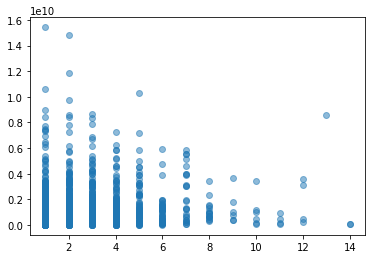

In [11]:
x = recent_profitable_movies['director_count']
y = recent_profitable_movies['profit']
plt.scatter(x, y, alpha=0.5)
plt.show()

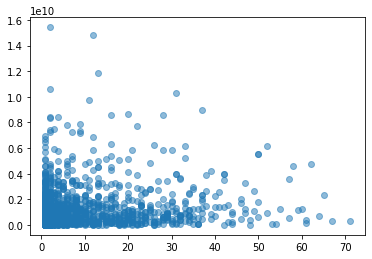

In [12]:
x = recent_profitable_movies['actor1_count']
y = recent_profitable_movies['profit']
plt.scatter(x, y, alpha=0.5)
plt.show()

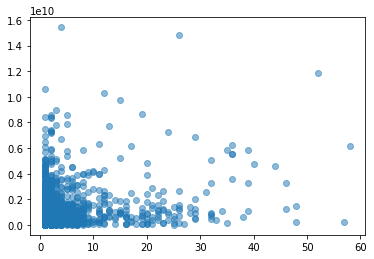

In [13]:
x = recent_profitable_movies['actor2_count']
y = recent_profitable_movies['profit']
plt.scatter(x, y, alpha=0.5)
plt.show()

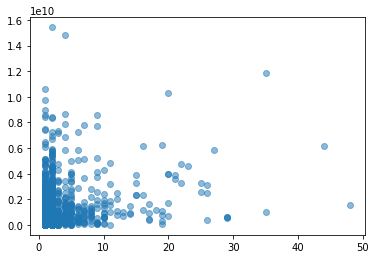

In [14]:
x = recent_profitable_movies['actor3_count']
y = recent_profitable_movies['profit']
plt.scatter(x, y, alpha=0.5)
plt.show()

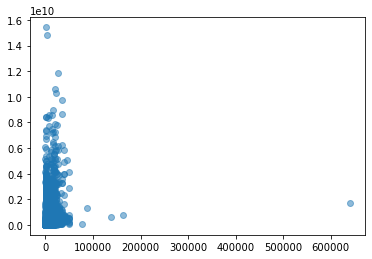

In [15]:
x = recent_profitable_movies['actor_1_facebook_likes']
y = recent_profitable_movies['profit']
plt.scatter(x, y, alpha=0.5)
plt.show()

In [16]:
recent_profitable_movies[['director_count', 'actor1_count', 'actor2_count', 'actor3_count', 'profit']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   director_count  1450 non-null   float64
 1   actor1_count    1450 non-null   float64
 2   actor2_count    1450 non-null   float64
 3   actor3_count    1450 non-null   float64
 4   profit          1450 non-null   float64
dtypes: float64(5)
memory usage: 56.8 KB


In [18]:
model=IsolationForest(contamination=float(0.1))
model.fit(recent_profitable_movies[['profit']])
anomaly = pd.DataFrame(model.predict(recent_profitable_movies[['profit']]))
anomaly.columns = ['anomaly']
recent_profitable_movies = pd.merge(recent_profitable_movies, anomaly, left_index = True, right_index = True)
recent_profitable_movies = recent_profitable_movies.loc[recent_profitable_movies['anomaly'] == 1].reset_index(drop = True)

In [22]:
X = recent_profitable_movies[['director_count', 'actor1_count', 'actor2_count', 'actor3_count']]
y = recent_profitable_movies['profit'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

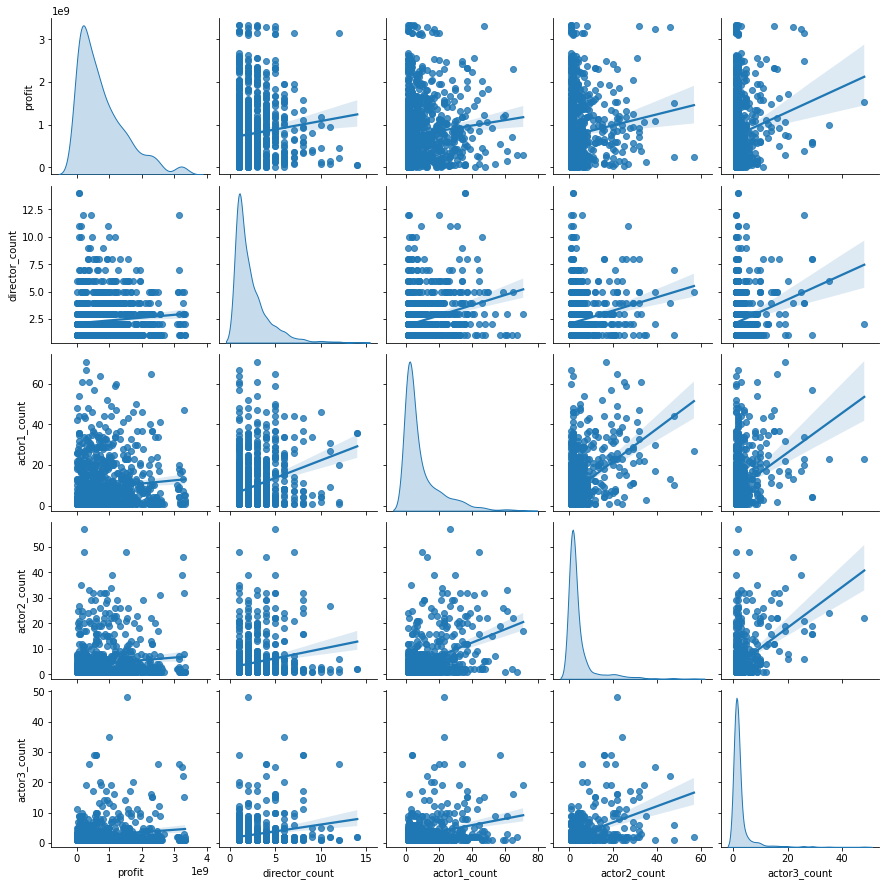

In [31]:
train_dataset = X_train.copy()
train_dataset.insert(0, "profit", y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

(1044, 4) (1044, 1)
MAE: 551155851.204


<AxesSubplot:>

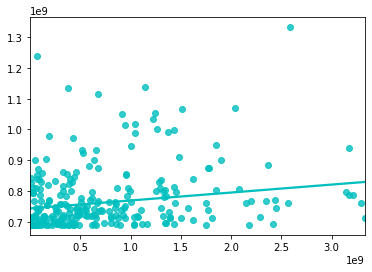

In [30]:
model = LinearRegression()
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

sns.regplot(x=y_test, y=y_pred, ci=None, color="c", fit_reg = True, robust = True)